In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from skimage.color import rgb2lab, lab2rgb, rgb2gray
import matplotlib.pyplot as plt
import cv2  
import os
#import image
from PIL import Image

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
Learning_rate = 0.001
Weight_decay = 0.9
RANDOM_SEED = 123
NUM_EPOCHS = 10
BATCH_SIZE = 128

## 1. A glance of data

In [4]:
image_gray = np.load('./image-colorization/l/gray_scale.npy')
image_lab1 = np.load('./image-colorization/ab/ab/ab1.npy')
image_lab2 = np.load('./image-colorization/ab/ab/ab2.npy')
image_lab3 = np.load('./image-colorization/ab/ab/ab3.npy')

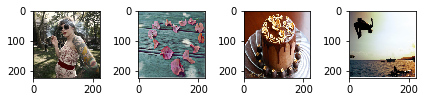

In [5]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    images = np.concatenate((np.array([image_gray[i]]).transpose(1,2,0),image_lab1[i]),axis=2)
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)

plt.tight_layout()

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [8]:
class ColorizationDataset(datasets.ImageFolder):
    '''Custom images folder, which converts images to grayscale before loading'''
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original).transpose(1,2,0)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = np.expand_dims(img_original, axis=0)
            img_original = np.concatenate((img_original,img_original,img_original),axis=0)
            img_original = torch.from_numpy(img_original).float()
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img_original, img_ab, target

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


train_dataset = ColorizationDataset(os.path.join('image-colorization', 'total'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = ColorizationDataset(os.path.join('image-colorization', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = ColorizationDataset(os.path.join('image-colorization', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## 2. Initilizeing Model

In [12]:
model = ColorizationResNet().to(DEVICE)
torch.manual_seed(RANDOM_SEED)

optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate)
criterion = nn.MSELoss().cuda() if torch.cuda.is_available() else nn.MSELosss()

## 2.1 Trainning Model

In [13]:
start_time = time.time()
minibatch_cost = []
epoch_cost, valid_cost = [], []
NUM_EPOCHS=50
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (input_gray, input_ab, targets) in enumerate(train_loader):
        
        input_gray = input_gray.to(DEVICE)
        input_ab = input_ab.to(DEVICE)
        targets = targets.to(DEVICE)
        
        output_ab = model.forward(input_gray)
        del input_gray
        cost = criterion(output_ab, input_ab)
        del output_ab, input_ab
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        minibatch_cost.append(cost)
        if not batch_idx % 25:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f  | Time elapsed: %.2f min' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost, (time.time() - start_time)/60))

    #cost_train = compute_mse(model, train_loader, device=DEVICE)
    #epoch_cost.append(cost_train)
    
    if not epoch % 5:
        model.eval()
        with torch.set_grad_enabled(False):
            cost_train = compute_mse(model, train_loader, device=DEVICE)
            epoch_cost.append(cost_train)
            cost_valid = compute_mse(model, valid_loader, device='cpu')
            valid_cost.append(cost_valid)
            print('Epoch: %03d/%03d Train Cost: %.4f | Valid Cost: %.f | Time elapsed: %.2f min' % (
                    epoch+1, NUM_EPOCHS, cost_train, cost_valid, (time.time() - start_time)/60))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 001/050 | Batch 000/156 | Cost: 0.0094  | Time elapsed: 0.08 min
Epoch: 001/050 | Batch 025/156 | Cost: 0.0040  | Time elapsed: 1.25 min
Epoch: 001/050 | Batch 050/156 | Cost: 0.0034  | Time elapsed: 2.41 min
Epoch: 001/050 | Batch 075/156 | Cost: 0.0038  | Time elapsed: 3.56 min
Epoch: 001/050 | Batch 100/156 | Cost: 0.0042  | Time elapsed: 4.74 min
Epoch: 001/050 | Batch 125/156 | Cost: 0.0043  | Time elapsed: 5.89 min
Epoch: 001/050 | Batch 150/156 | Cost: 0.0039  | Time elapsed: 7.04 min
Epoch: 001/050 Train Cost: 376.8513 | Valid Cost: 492 | Time elapsed: 13.51 min
Time elapsed: 13.52 min
Epoch: 002/050 | Batch 000/156 | Cost: 0.0035  | Time elapsed: 13.56 min
Epoch: 002/050 | Batch 025/156 | Cost: 0.0040  | Time elapsed: 14.65 min
Epoch: 002/050 | Batch 050/156 | Cost: 0.0032  | Time elapsed: 15.74 min
Epoch: 002/050 | Batch 075/156 | Cost: 0.0044  | Time elapsed: 16.83 min
Epoch: 002/050 | Batch 100/156 | Cost: 0.0044  | Time elapsed: 17.92 min
Epoch: 002/050 | Batch 125/

### 2.2 Saving and reloading model

In [14]:
checkpoint = {'epoch': epoch+1,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'pretrained/Regression.pth')

In [15]:
state = torch.load('pretrained/Regression.pth')

In [16]:
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

### 2.3 Cheaking Loss

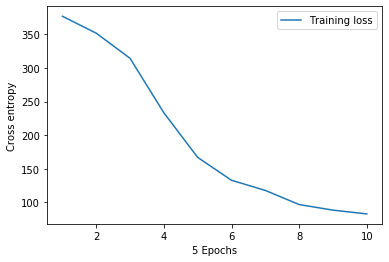

In [19]:
plt.plot(range(1, 10+1), epoch_cost, label='Training loss')
#plt.plot(range(1, 10+1), valid_cost, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('5 Epochs')
plt.show()

### 3. Final Output

In [50]:
BATCH_STOP=1
img_num_start=0
img_num=2

In [51]:
model.eval()
for batch_idx, (input_gray, input_ab, targets) in enumerate(valid_loader):
    with torch.set_grad_enabled(False):

        input_gray = input_gray.to(DEVICE)
        input_ab = input_ab.to(DEVICE)
        targets = targets.to(DEVICE)

        output_ab = model.forward(input_gray)
    if batch_idx == BATCH_STOP:
        break

In [52]:
input_gray = input_gray.to('cpu').numpy()*255
input_gray = np.expand_dims(input_gray[:,0,:,:], axis=1)
input_gray = input_gray.astype('uint8')
input_ab = input_ab.to('cpu').numpy()*255
input_ab = input_ab.astype('uint8')
output_ab = output_ab.to('cpu').numpy()*255
output_ab = output_ab.astype('uint8')

### 3.1 Original Input

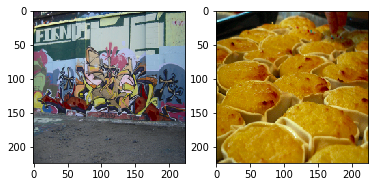

In [53]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],input_ab[img_num_start+i]),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'original'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()

### 3.2 Grayscale Input

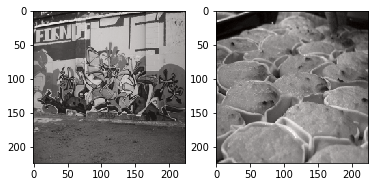

In [54]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],np.zeros([2,224,224])+129),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'gray'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()

### 3.3 Colorized Output

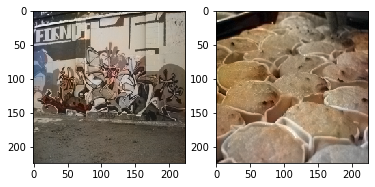

In [55]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],output_ab[img_num_start+i]),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'colorized'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()